### aim: 

### date: 

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [4]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

## Who contributes to pp?

get (biomass) * tgfunc * t

    ~/scratch/modelTest/LOP1/NEMO/TOP_SRC/PlankTOM]$

    vim bgcpro.F90
    pcmax(jl) = rn_mumpft(jl)*(1.+rn_resphy(jl))/rjjss 
     ! number of seconds in day (rjss)
    pctnut=pcmax(jl) * xlimpft(ji,jj,jk,jl) * tgfunc(ji,jj,jk,jl)
    pcphot(jl) = pctnut * xlim8
    prophy(ji,jj,jk,jl,1) = pcphot(jl) * trn(ji,jj,jk,jl) * rfact


    vim bgcbio.F90
    ppint(ji,jj) = ppint(ji,jj)+prophy(ji,jj,jk,jl,1) * fse3t(ji,jj,jk) * 1e3 * rfactr
    
    
    vim bgcint.F90
    ztemp = 10.
    tgfunc(ji,jj,jk,jl) = exp(-1.*(tsn(ji,jj,jk,1)-rn_mutpft(jl))**2./rn_mudpft(jl)**2.)
    ztmax = (1./5. + 4./5.*max(tsn(ji,jj,jk,1),-1.8)/(ztemp+rtrn))*tgfunc(ji,jj,jk,jpcoc)
    tgfunc(ji,jj,jk,jpcoc) = min(ztmax,tgfunc(ji,jj,jk,jpcoc))
    
    ## this is taken from ~/scratch/ModelRuns/TOM12_TJ_LA02]$ vim namelist.trc.sms
    
    pftv = ['dia','mix','coc','pic','pha','fix']
    rn_mumpft =    np.array([ 1.3    ,  1.1    ,  1.0    ,  0.8    ,  1.4    ,  0.2    ,])
    rn_resphy =     np.array([0.12   ,  0.15   ,  0.15   ,  0.15   ,  0.15   ,  0.15   ,])
    rn_mutpft =     np.array([18.80   ,  22.00  ,   31.60  , 31.60  ,  23.60  ,  33.20  , \
                              23.20  ,  34.00  ,  20.40  ,  24.80  ,  15.60  ,  27.60  ,])
    rn_mudpft =     np.array([20.0    ,  20.0   ,   20.0   , 20.0   ,  18.8   ,  20.0   , \
                              17.2   ,  20.0   ,   7.4   ,  11.2   ,  13.0   ,  8.2    ,])

    # pcmax(jl) = rn_mumpft(jl)*(1.+rn_resphy(jl))/rjjss 
    #  ! number of seconds in day (rjss)
    # pctnut=pcmax(jl) * xlimpft(ji,jj,jk,jl) * tgfunc(ji,jj,jk,jl)
    # pcphot(jl) = pctnut * xlim8
    # prophy(ji,jj,jk,jl,1) = pcphot(jl) * trn(ji,jj,jk,jl) * rfact


    # vim bgcbio.F90
    # ppint(ji,jj) = ppint(ji,jj)+prophy(ji,jj,jk,jl,1) * fse3t(ji,jj,jk) * 1e3 * rfactr


In [5]:
def get_tgfunc(tsn,pft, verbose = False):

    rn_mutpft =     np.array([18.80   ,  22.00  ,   31.60  , 31.60  ,  23.60  ,  33.20  , \
                              23.20  ,  34.00  ,  20.40  ,  24.80  ,  15.60  ,  27.60  ,])
    rn_mudpft =     np.array([20.0    ,  20.0   ,   20.0   , 20.0   ,  18.8   ,  20.0   , \
                              17.2   ,  20.0   ,   7.4   ,  11.2   ,  13.0   ,  8.2    ,])
    
    pftv = ['dia','mix','coc','pic','pha','fix']
    index_of_pft= pftv.index(pft)
    
    tgfunc = np.exp(-1.*(tsn-rn_mutpft[index_of_pft])**2./rn_mudpft[index_of_pft]**2.)

    
    if pft == 'coc':
        ztemp = 10.
        ztmax = (1./5. + 4./5.*max(tsn,-1.8)/(ztemp))*tgfunc
        tgfunc = min(ztmax,tgfunc)
        
    if verbose:
        print(tgfunc)
        
    return tgfunc
        
get_tgfunc(8,'coc',True)

0.20872172215767953


0.20872172215767953

168


Text(0.5, 0, 'deg C')

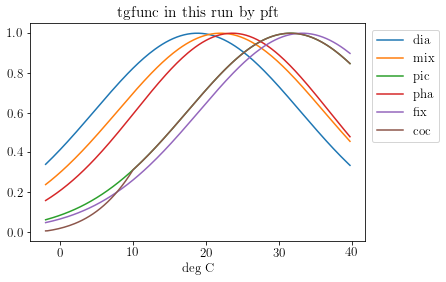

In [24]:
pftv = ['dia','mix','pic','pha','fix']

tsn = np.arange(-2,40,0.25)
print(len(tsn))
funcs = np.zeros([5,len(tsn)])

for i in range(0,5):
    funcs[i,:] = get_tgfunc(tsn,pftv[i])

tsn = np.arange(-2,40,0.25)
cocs = np.copy(tsn)

for i in range(0,len(tsn)):
    cocs[i] = get_tgfunc(tsn[i],'coc')
plt.figure()
for i in range(0,5):
    plt.plot(tsn, funcs[i,:], label = pftv[i])
plt.plot(tsn, cocs[:], label = 'coc')
    
plt.legend(bbox_to_anchor = [1,1])
plt.title('tgfunc in this run by pft')
plt.xlabel('deg C')

In [29]:
def get_prophy(tgfunc, pft, xlimpft, xlim8, conc_pft):
    
    rfact = 5760.0000000000000 #(tracer time step)
    rjjss = 60*60*24 #secondsday
    
    pftv = ['dia','mix','coc','pic','pha','fix']
    index_of_pft= pftv.index(pft)
    
    rn_mumpft =    np.array([ 1.3    ,  1.1    ,  1.0    ,  0.8    ,  1.4    ,  0.2    ,])
    rn_resphy =     np.array([0.12   ,  0.15   ,  0.15   ,  0.15   ,  0.15   ,  0.15   ,])
    
    pcmax = rn_mumpft[index_of_pft]*(1.+rn_resphy[index_of_pft])/rjjss 
    pctnut=pcmax * xlimpft * tgfunc
    pcphot = pctnut * xlim8
    prophy = pcphot * conc_pft
    
    return prophy

In [7]:
LoP = '/gpfs/data/greenocean/software/runs/TOM12_TJ_LA02//ORCA2_1m_19580101_19581231_LoP_T.nc'
diad = '/gpfs/data/greenocean/software/runs/TOM12_TJ_LA02//ORCA2_1m_19580101_19581231_diad_T.nc'
ptrc = '/gpfs/data/greenocean/software/runs/TOM12_TJ_LA02//ORCA2_1m_19580101_19581231_ptrc_T.nc'
grid = '/gpfs/data/greenocean/software/runs/TOM12_TJ_LA02//ORCA2_1m_19580101_19581231_grid_T.nc'

In [8]:
LoPd = xr.open_dataset(LoP)
diadd = xr.open_dataset(diad)
ptrcd = xr.open_dataset(ptrc)
gridd = xr.open_dataset(grid)

In [68]:
def get_tgfunc(tsn,pft, verbose = False):

    rn_mutpft =     np.array([18.80   ,  22.00  ,   31.60  , 31.60  ,  23.60  ,  33.20  , \
                              23.20  ,  34.00  ,  20.40  ,  24.80  ,  15.60  ,  27.60  ,])
    rn_mudpft =     np.array([20.0    ,  20.0   ,   20.0   , 20.0   ,  18.8   ,  20.0   , \
                              17.2   ,  20.0   ,   7.4   ,  11.2   ,  13.0   ,  8.2    ,])
    
    pftv = ['dia','mix','coc','pic','pha','fix']
    index_of_pft= pftv.index(pft)
    
    tgfunc = np.exp(-1.*(tsn-rn_mutpft[index_of_pft])**2./rn_mudpft[index_of_pft]**2.)

    
    if pft == 'coc':
        ztemp = 10.
        ztmax = (1./5. + 4./5.*max(tsn,-1.8)/(ztemp))*tgfunc
        tgfunc = min(ztmax,tgfunc)
        
    if verbose:
        print(tgfunc)
        
    return tgfunc


def get_prophy(tgfunc, pft, xlimpft, xlim8, conc_pft):
    
    rfact = 5760.0000000000000 #(tracer time step)
    rjjss = 60*60*24 #secondsday
    
    pftv = ['dia','mix','coc','pic','pha','fix']
    index_of_pft= pftv.index(pft)
    
    rn_mumpft =    np.array([ 1.3    ,  1.1    ,  1.0    ,  0.8    ,  1.4    ,  0.2    ,])
    rn_resphy =     np.array([0.12   ,  0.15   ,  0.15   ,  0.15   ,  0.15   ,  0.15   ,])
    
    pcmax = rn_mumpft[index_of_pft]*(1.+rn_resphy[index_of_pft])/rjjss 
    pctnut=pcmax * xlimpft * tgfunc
    pcphot = pctnut * xlim8
    prophy = pcphot * conc_pft
    
    return prophy

def get_datasets(LoP, diad, ptrc, grid):

    ptrcd = xr.open_dataset(ptrc)
    LoPd = xr.open_dataset(LoP)
    gridd = xr.open_dataset(grid)
    diadd = xr.open_dataset(diad)
    
    return ptrcd, LoPd, gridd, diadd
    
def get_prophytot(x, y, z, t, pft, ptrcd, LoPd, gridd, diadd):
    
    tsn = gridd.votemper[t,z,y,x]
    tgfunc = get_tgfunc(tsn,pft, verbose = False)
    tLV = f'LV_{pft}'
    xlimpft = LoPd[tLV][t,z,y,x]
    
    tlim8 = f'lim8light_{pft}'
    xlim8 = diadd[tlim8][t,z,y,x]
    
    PFT = pft.upper()
    conc_pft = ptrcd[PFT][t,z,y,x]
    
    prophy = get_prophy(tgfunc, pft, xlimpft, xlim8, conc_pft)
    
    return prophy

def make_nc(LoP, diad, ptrc, grid, savestr, pft):
    
    #pftv = ['dia','mix','coc','pic','pha','fix']
    ptrcd, LoPd, gridd, diadd = get_datasets(LoP, diad, ptrc, grid)
    
    # for t in range(0,12):
    #     for x in range(0,182):
    #         for y in range(0,149):
    #             for z in range(0,31):
    
    tsn = gridd.votemper.values
    prophyar = np.zeros_like(tsn)
    gridd['prophy'] = gridd.votemper.copy()
    
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')

    for t in range(0,12):
        t1 = time.time()
        for x in range(80,160):
            for y in range(70,130): #natl
                for z in range(0,15):
                    # for pft in pftv:
                    if tmesh.tmask[0,z,y,x] == 0:
                        pass
                    else:
                        prophyar[t,z,y,x] = get_prophytot(x, y, z, t, pft, ptrcd, LoPd, gridd, diadd)
        t2 = time.time()
        print(t2-t1)

    gridd['prophy'].values = prophyar
    w_sel = gridd['prophy']
    w_sel.to_netcdf(savestr)

SyntaxError: invalid syntax (2075546673.py, line 43)

In [69]:
print(ptrcd.DIA[0,0:16,120,100])
print(diadd.lim8light_pic[0,:,120,100])
ptrcd.deptht[0:15]

<xarray.DataArray 'DIA' (deptht: 16)>
array([1.163541e-10, 1.173441e-10, 1.201576e-10, 2.074935e-10, 1.906321e-09,
       1.271492e-08, 4.623080e-08, 9.950726e-08, 1.387204e-07, 1.549121e-07,
       1.486844e-07, 1.336490e-07, 1.105936e-07, 8.167161e-08, 8.166111e-08,
       0.000000e+00], dtype=float32)
Coordinates:
    nav_lat        float32 58.06
    nav_lon        float32 -84.07
  * deptht         (deptht) float32 5.0 15.0 25.0 35.01 ... 142.2 159.0 182.0
    time_centered  object 1958-01-16 12:00:00
    time_counter   object 1958-01-16 12:00:00
Attributes:
    long_name:           Diatom Concentration
    units:               mol/L
    online_operation:    average
    interval_operation:  5760 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5760 s)
<xarray.DataArray 'lim8light_pic' (deptht: 31)>
array([0.56259 , 0.401898, 0.326083, 0.266476, 0.219269, 0.19748 , 0.177891,
       0.155449, 0.132374, 0.110488, 0.090399, 0.072706, 0.05665 , 0.041903,


<xarray.DataArray 'deptht' (deptht: 15)>
array([  4.999938,  15.000288,  25.001759,  35.005413,  45.013317,  55.0295  ,
        65.061806,  75.12551 ,  85.25037 ,  95.494286, 105.96992 , 116.89624 ,
       128.6979  , 142.19525 , 158.96062 ], dtype=float32)
Coordinates:
  * deptht   (deptht) float32 5.0 15.0 25.0 35.01 ... 116.9 128.7 142.2 159.0
Attributes:
    long_name:  Vertical T levels
    units:      m
    axis:       Z
    positive:   down
    bounds:     deptht_bounds

In [42]:
diadd.lim8light_dia

<xarray.DataArray 'lim8light_dia' (time_counter: 12, deptht: 31, y: 149, x: 182)>
[10087896 values with dtype=float32]
Coordinates:
    nav_lat        (y, x) float32 -78.19 -78.19 -78.19 -78.19 ... 0.0 0.0 0.0
    nav_lon        (y, x) float32 78.0 80.0 82.0 84.0 86.0 ... 0.0 0.0 0.0 0.0
  * deptht         (deptht) float32 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
    time_centered  (time_counter) object 1958-01-16 12:00:00 ... 1958-12-16 1...
  * time_counter   (time_counter) object 1958-01-16 12:00:00 ... 1958-12-16 1...
Dimensions without coordinates: y, x
Attributes:
    long_name:           light limitation lim8 DIA
    units:               -
    online_operation:    average
    interval_operation:  5760 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5760 s)